# AeroAcoustics.jl
This notebook demonstrates the basic functionality of the AeroAcoustics.jl package.

First obtain a version of julia from https://julialang.org, start the application and run:
```
using Pkg
] add https://gitlab.windenergy.dtu.dk/ollyl/AeroAcoustics.jl.git
```

In [1]:
using AeroAcoustics

Now run the tests to see if everything runs smoothly  
```
]test AeroAcoustics
```
This will start the tests and hopefully you'll see that all tests pass
```
Test Summary: | Pass  Total
AeroAcoustics |    5      5
   Testing AeroAcoustics tests passed
```


The testset downloads to example files, that are store in the .julia directory. Something similar to
```
~/.julia/packages/AeroAcoustics/Dlv4w/test/data
```
Find the files and copy their path.

Now, start by importing the datasets. If it has not previously been added, run
```
]add HDF5
```

In [2]:
using HDF5

In [3]:
srcdir = "/Users/oliver/.julia/packages/AeroAcoustics/Dlv4w/test/data/test1_timeseries.h5"
t = h5read(srcdir, "MicrophoneData/microphoneDataPa")
fs = h5read(srcdir, "MicrophoneData/fs")

65536

Now compute the cross spectral matrix, optionally also add DSP
```
]add DSP
```

In [4]:
using DSP

In [5]:
CSM1,fc = csm(t;n=1024,noverlap=div(1024,2),fs=fs,win=DSP.hanning(1024))

(Complex{Float32}[2.66121e-6+0.0im 2.64652e-6-0.0im … 2.38533e-6-0.0im 2.38914e-6-0.0im; 2.64652e-6+0.0im 2.86069e-6+0.0im … 2.52108e-6-0.0im 2.59664e-6-0.0im; … ; 2.38533e-6+0.0im 2.52108e-6+0.0im … 2.47832e-6+0.0im 2.52581e-6-0.0im; 2.38914e-6+0.0im 2.59664e-6+0.0im … 2.52581e-6+0.0im 2.79164e-6+0.0im]

Complex{Float32}[1.81212e-5+0.0im 1.74654e-5+1.17014e-6im … 1.40854e-5+6.13438e-6im 1.18786e-5+8.40641e-6im; 1.74654e-5-1.17014e-6im 1.6999e-5+0.0im … 1.40328e-5+4.99488e-6im 1.20777e-5+7.3317e-6im; … ; 1.40854e-5-6.13438e-6im 1.40328e-5-4.99488e-6im … 1.32979e-5+0.0im 1.24091e-5+2.56634e-6im; 1.18786e-5-8.40641e-6im 1.20777e-5-7.3317e-6im … 1.24091e-5-2.56634e-6im 1.21968e-5+0.0im]

Complex{Float32}[6.90312e-5+0.0im 6.66713e-5+5.14142e-6im … 5.08553e-5+2.93059e-5im 3.96399e-5+3.88545e-5im; 6.66713e-5-5.14142e-6im 6.48008e-5+0.0im … 5.13628e-5+2.45463e-5im 4.12463e-5+3.46336e-5im; … ; 5.08553e-5-2.93059e-5im 5.13628e-5-2.45463e-5im … 5.04477e-5+0.0im 4.63908e-5+1.19839e-5im; 3.96399e-

Now read the microphone geometry and start setting up beamforming

In [6]:
micgeom = h5read(srcdir, "MicrophoneData/arrayGeom")

3×84 Array{Float64,2}:
 -0.16772   -0.36164   -0.37212  -0.57652   …  -0.82407  -0.61627  -0.63689
  0.095093   0.041345   0.20259   0.057883     -0.52936  -0.52079  -0.73896
  0.0        0.0        0.0       0.0           0.0       0.0       0.0    

In [7]:
env = Environment(z0=1.6,
                  micgeom=micgeom,
                  Nx = 21,
                  Ny = 21,
                  flim=(100,10000),
                  f=fc,
                  xlim=(-0.5,0.5),
                  ylim=(-0.5,0.5))

Environment{Float64,Float64,Array{Int64,1}}
  micgeom: Array{Float64}((3, 84)) [-0.16772 -0.36164 … -0.61627 -0.63689; 0.095093 0.041345 … -0.52079 -0.73896; 0.0 0.0 … 0.0 0.0]
  z0: Float64 1.6
  f: Array{Int64}((513,)) [0, 64, 128, 192, 256, 320, 384, 448, 512, 576  …  32192, 32256, 32320, 32384, 32448, 32512, 32576, 32640, 32704, 32768]
  Nx: Int64 21
  Ny: Int64 21
  xlim: Tuple{Float64,Float64}
  ylim: Tuple{Float64,Float64}
  flim: Tuple{Int64,Int64}
  c: Float64 343.0
  Ma: Float64 0.0
  fn: Array{Int64}((155,)) [128, 192, 256, 320, 384, 448, 512, 576, 640, 704  …  9408, 9472, 9536, 9600, 9664, 9728, 9792, 9856, 9920, 9984]
  M: Int64 84
  N: Int64 441
  Nf: Int64 155
  rx: StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
  ry: StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
  Rxy: Array{Float64}((3, 441)) [-0.5 -0.45 … 0.45 0.5; -0.5 -0.5 … 0.5 0.5; 1.6 1.6 … 1.6 1.6]
  D0: Array{Float64}((441,)) [1.74929, 1.73566, 

Compute steering vectors and beamforming

In [8]:
v1 = steeringvectors(env)
v1c = convert(Array{Complex{Float32},3},v1) # Need to convert manually at the moment... Will be fixed later
b = beamforming(CSM1[:,:,1:39],v1c)         # Need to select frequencies manually... Will be fixed later

441×39 Array{Float32,2}:
 2.27894e-6  1.04917e-5  2.77341e-5  1.83135e-5  …  6.60244e-9   7.40225e-9 
 2.32415e-6  1.09071e-5  2.96759e-5  2.04803e-5     8.45144e-9   5.76375e-9 
 2.36635e-6  1.12965e-5  3.15321e-5  2.26185e-5     1.52334e-8   9.78006e-9 
 2.40507e-6  1.16537e-5  3.32642e-5  2.46693e-5     1.38801e-8   9.89683e-9 
 2.43985e-6  1.19729e-5  3.48334e-5  2.6571e-5      4.48567e-9   3.69695e-9 
 2.47025e-6  1.22484e-5  3.62024e-5  2.82623e-5  …  5.19213e-10  8.03346e-10
 2.49589e-6  1.24753e-5  3.7337e-5   2.96848e-5     3.65594e-9   3.22912e-9 
 2.51643e-6  1.26492e-5  3.82076e-5  3.07872e-5     4.83725e-9   3.58581e-9 
 2.53161e-6  1.27668e-5  3.87906e-5  3.15278e-5     2.01424e-9   7.88442e-10
 2.54122e-6  1.28256e-5  3.90694e-5  3.18776e-5     1.26009e-9   1.66402e-9 
 2.54513e-6  1.28244e-5  3.90356e-5  3.1822e-5   …  6.40709e-9   9.62367e-9 
 2.5433e-6   1.27628e-5  3.8689e-5   3.13617e-5     1.51654e-8   2.1336e-8  
 2.53575e-6  1.26421e-5  3.80381e-5  3.05131e-5    

Plot results...

In [9]:
using Plots

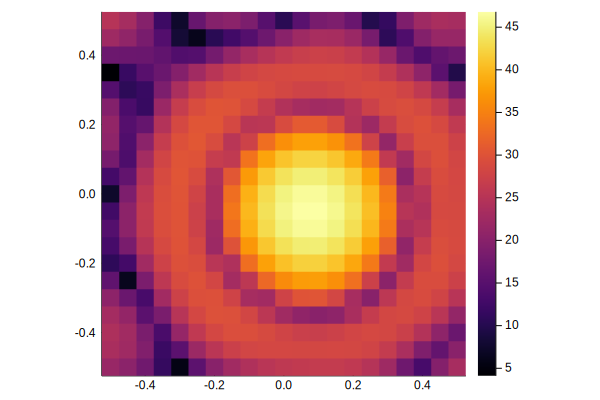

In [13]:
heatmap(env.rx,env.ry,reshape(SPL.(b[:,20]),env.Nx,env.Ny),aspect_ratio=1)